In [1]:
!pip install torch torchvision matplotlib scikit-learn tqdm


'pip' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


IMPORTANDO BIBLIOTECAS

In [5]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


CONFIGURAÇÕES GERAIS

In [6]:
# Configurações gerais
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()


IMPORTANDO DATA SET

In [7]:
# Caminhos do dataset
dataset_root = './DataSet'
training_dir = os.path.join(dataset_root, 'Training')
validation_dir = os.path.join(dataset_root, 'Validation')
testing_dir = os.path.join(dataset_root, 'Testing')


TRANSFORMAÇÃO DAS IMAGENS, CARREGAMENTO DO DATASET E CRIAÇÃO DOS DATA LOADERS

In [8]:
# Transformações para as imagens
transform = {
    'train': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Carregar datasets
datasets_dict = {
    'train': datasets.ImageFolder(root=training_dir, transform=transform['train']),
    'val': datasets.ImageFolder(root=validation_dir, transform=transform['val_test']),
    'test': datasets.ImageFolder(root=testing_dir, transform=transform['val_test'])
}

# Criar DataLoaders
def create_dataloaders(batch_size):
    return {
        'train': DataLoader(datasets_dict['train'], batch_size=batch_size, shuffle=True),
        'val': DataLoader(datasets_dict['val'], batch_size=batch_size, shuffle=False),
        'test': DataLoader(datasets_dict['test'], batch_size=batch_size, shuffle=False)
    }


CONFIGURAÇÃO DOS MODELOS

In [17]:
# Configurar modelos
num_classes = len(datasets_dict['train'].classes)

resnet_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# DenseNet121
densenet_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, num_classes)

# Inception v3
inception_model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT, aux_logits=True)
inception_model.fc = nn.Linear(inception_model.fc.in_features, num_classes)

FUNÇÃO DE TREINAMENTO

In [10]:
# Função de treinamento
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, model_name="model"):
    model = model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Treinando - Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            if isinstance(outputs, tuple):  # Para Inception v3
                main_output, aux_output = outputs
                loss = criterion(main_output, labels) + 0.4 * criterion(aux_output, labels)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs[0] if isinstance(outputs, tuple) else outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_accuracy = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validando"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    main_output = outputs[0]
                    loss = criterion(main_output, labels)
                else:
                    loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(main_output if isinstance(outputs, tuple) else outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_accuracy = 100 * correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%\n")

    torch.save({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }, f"{model_name}_metrics.pth")

    return model

FUNÇÃO DE AVALIAÇÃO E PLOTAGEM DA MATRIZ DE CONFUSÃO

In [11]:
# Função de avaliação e matriz de confusão
def evaluate_model(model, test_loader, model_name="model"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Usar apenas a saída principal
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=datasets_dict['train'].classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.show()

In [12]:
# Função para otimização de hiperparâmetros
def hyperparameter_optimization(model, param_grid, epochs=5):
    best_model = None
    best_accuracy = 0.0
    best_params = {}

    for trial in range(param_grid['trials']):
        lr = random.choice(param_grid['lr'])
        batch_size = random.choice(param_grid['batch_size'])
        optimizer_name = random.choice(param_grid['optimizer'])

        print(f"Teste {trial+1}: lr={lr}, batch_size={batch_size}, optimizer={optimizer_name}")

        dataloaders = create_dataloaders(batch_size)

        optimizer = Adam(model.parameters(), lr=lr) if optimizer_name == 'Adam' else SGD(model.parameters(), lr=lr, momentum=0.9)

        trained_model = train_model(model, dataloaders['train'], dataloaders['val'], nn.CrossEntropyLoss(), optimizer, epochs=epochs)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        accuracy = 100 * correct / total
        print(f"Acurácia de Validação: {accuracy:.2f}%")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = trained_model
            best_params = {'lr': lr, 'batch_size': batch_size, 'optimizer': optimizer_name}

    print(f"\nMelhores Hiperparâmetros: {best_params}, Melhor Acurácia: {best_accuracy:.2f}%")
    return best_model, best_params

# Grid de hiperparâmetros
param_grid = {
    'lr': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32, 64],
    'optimizer': ['Adam', 'SGD'],
    'trials': 2
}

In [21]:

# Treinar com parâmetros fixos
def train_with_fixed_params(model, dataloaders, epochs=5, lr=0.001, batch_size=32, optimizer_name="Adam", model_name="model"):
    optimizer = Adam(model.parameters(), lr=lr) if optimizer_name == 'Adam' else SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    return train_model(model, dataloaders['train'], dataloaders['val'], criterion, optimizer, epochs=epochs, model_name=model_name)


TREINO E AVALIAÇÃO DO MODELO RESNET

--- ResNet ---
Treinamento com Otimização de Hiperparâmetros
Teste 1: lr=0.01, batch_size=32, optimizer=SGD


Validando: 100%|██████████| 28/28 [00:44<00:00,  1.60s/it]


Epoch 1/5, Loss: 0.1008, Train Accuracy: 96.86%
Validation Loss: 0.0736, Validation Accuracy: 97.00%



Validando: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Epoch 2/5, Loss: 0.0832, Train Accuracy: 97.07%
Validation Loss: 0.0319, Validation Accuracy: 98.85%



Validando: 100%|██████████| 28/28 [00:45<00:00,  1.62s/it]


Epoch 3/5, Loss: 0.0667, Train Accuracy: 97.35%
Validation Loss: 0.0226, Validation Accuracy: 99.08%



Validando: 100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


Epoch 4/5, Loss: 0.0642, Train Accuracy: 97.74%
Validation Loss: 0.0293, Validation Accuracy: 99.42%



Validando: 100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


Epoch 5/5, Loss: 0.0501, Train Accuracy: 97.98%
Validation Loss: 0.0152, Validation Accuracy: 99.65%

Acurácia de Validação: 99.65%
Teste 2: lr=0.001, batch_size=64, optimizer=Adam


Validando: 100%|██████████| 14/14 [00:45<00:00,  3.27s/it]


Epoch 1/5, Loss: 0.1696, Train Accuracy: 94.46%
Validation Loss: 0.4599, Validation Accuracy: 86.16%



Validando: 100%|██████████| 14/14 [00:45<00:00,  3.24s/it]


Epoch 2/5, Loss: 0.1201, Train Accuracy: 96.66%
Validation Loss: 0.0844, Validation Accuracy: 96.54%



Validando: 100%|██████████| 14/14 [00:45<00:00,  3.25s/it]


Epoch 3/5, Loss: 0.0759, Train Accuracy: 97.39%
Validation Loss: 0.1133, Validation Accuracy: 95.04%



Validando: 100%|██████████| 14/14 [00:45<00:00,  3.22s/it]


Epoch 4/5, Loss: 0.0621, Train Accuracy: 97.28%
Validation Loss: 0.1221, Validation Accuracy: 95.50%



Validando: 100%|██████████| 14/14 [00:46<00:00,  3.33s/it]


Epoch 5/5, Loss: 0.0742, Train Accuracy: 97.18%
Validation Loss: 0.0700, Validation Accuracy: 97.92%

Acurácia de Validação: 97.92%

Melhores Hiperparâmetros: {'lr': 0.01, 'batch_size': 32, 'optimizer': 'SGD'}, Melhor Acurácia: 99.65%
Accuracy: 0.7741
Precision: 0.8382
Recall: 0.7741
F1 Score: 0.7369


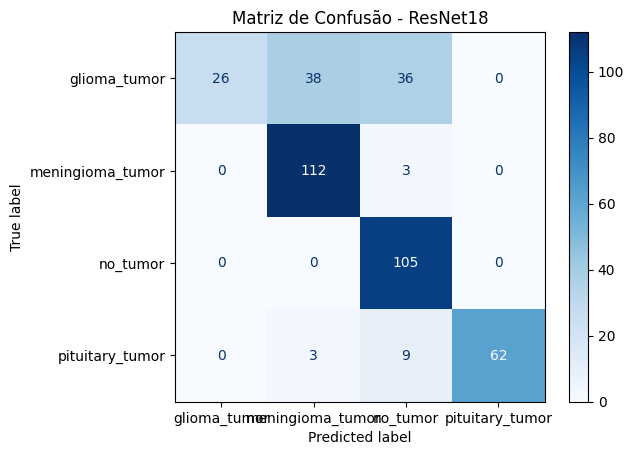

Treinamento com Parâmetros Fixos


Validando: 100%|██████████| 28/28 [00:54<00:00,  1.96s/it]


Epoch 1/5, Loss: 0.1749, Train Accuracy: 94.56%
Validation Loss: 0.0588, Validation Accuracy: 98.39%



Validando: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


Epoch 2/5, Loss: 0.1480, Train Accuracy: 95.26%
Validation Loss: 0.5208, Validation Accuracy: 84.66%



Validando: 100%|██████████| 28/28 [00:50<00:00,  1.81s/it]


Epoch 3/5, Loss: 0.0981, Train Accuracy: 96.38%
Validation Loss: 0.0884, Validation Accuracy: 96.89%



Validando: 100%|██████████| 28/28 [00:47<00:00,  1.71s/it]


Epoch 4/5, Loss: 0.0943, Train Accuracy: 96.62%
Validation Loss: 0.0704, Validation Accuracy: 97.12%



Validando: 100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


Epoch 5/5, Loss: 0.0844, Train Accuracy: 96.97%
Validation Loss: 0.4129, Validation Accuracy: 86.51%

Accuracy: 0.7462
Precision: 0.7451
Recall: 0.7462
F1 Score: 0.7310


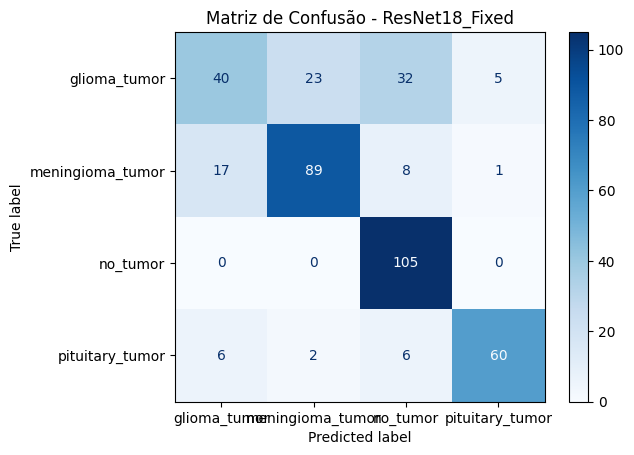

In [18]:
# ResNet
print("--- ResNet ---")
print("Treinamento com Otimização de Hiperparâmetros")
best_resnet, resnet_params = hyperparameter_optimization(resnet_model, param_grid, epochs=5)
evaluate_model(best_resnet, create_dataloaders(32)['test'], model_name="ResNet18")

print("Treinamento com Parâmetros Fixos")
fixed_dataloaders = create_dataloaders(32)
trained_resnet_fixed = train_with_fixed_params(resnet_model, fixed_dataloaders, epochs=5, lr=0.001, batch_size=32, optimizer_name="Adam", model_name="ResNet18_Fixed")
evaluate_model(trained_resnet_fixed, fixed_dataloaders['test'], model_name="ResNet18_Fixed")


In [19]:
torch.cuda.empty_cache()

TREINO E AVALIAÇÃO DO MODELO INCEPTION V3

--- Inception ---
Treinamento com Parâmetros Fixos


Validando: 100%|██████████| 28/28 [01:34<00:00,  3.37s/it]


Epoch 1/5, Loss: 0.7474, Train Accuracy: 83.34%
Validation Loss: 1.1105, Validation Accuracy: 61.82%



Validando: 100%|██████████| 28/28 [01:32<00:00,  3.32s/it]


Epoch 2/5, Loss: 0.3427, Train Accuracy: 90.42%
Validation Loss: 0.1930, Validation Accuracy: 93.43%



Validando: 100%|██████████| 28/28 [01:33<00:00,  3.33s/it]


Epoch 3/5, Loss: 0.3040, Train Accuracy: 92.65%
Validation Loss: 0.4834, Validation Accuracy: 83.28%



Validando: 100%|██████████| 28/28 [01:33<00:00,  3.34s/it]


Epoch 4/5, Loss: 0.2864, Train Accuracy: 92.86%
Validation Loss: 0.5277, Validation Accuracy: 81.89%



Validando: 100%|██████████| 28/28 [01:33<00:00,  3.34s/it]


Epoch 5/5, Loss: 0.2151, Train Accuracy: 95.12%
Validation Loss: 0.0847, Validation Accuracy: 98.15%

Accuracy: 0.7411
Precision: 0.7975
Recall: 0.7411
F1 Score: 0.7133


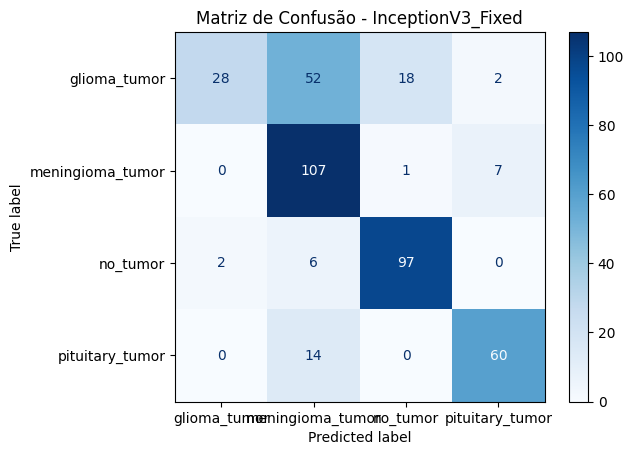

Treinamento com Otimização de Hiperparâmetros
Teste 1: lr=0.001, batch_size=32, optimizer=Adam


Validando: 100%|██████████| 28/28 [01:31<00:00,  3.28s/it]


Epoch 1/5, Loss: 0.3953, Train Accuracy: 91.01%
Validation Loss: 0.3245, Validation Accuracy: 91.12%



Validando: 100%|██████████| 28/28 [01:31<00:00,  3.28s/it]


Epoch 2/5, Loss: 0.2586, Train Accuracy: 94.25%
Validation Loss: 0.2619, Validation Accuracy: 90.77%



Validando: 100%|██████████| 28/28 [01:30<00:00,  3.23s/it]


Epoch 3/5, Loss: 0.2214, Train Accuracy: 95.02%
Validation Loss: 0.0777, Validation Accuracy: 96.77%



Validando: 100%|██████████| 28/28 [01:32<00:00,  3.31s/it]


Epoch 4/5, Loss: 0.1798, Train Accuracy: 95.96%
Validation Loss: 0.5692, Validation Accuracy: 89.73%



Validando: 100%|██████████| 28/28 [01:32<00:00,  3.29s/it]


Epoch 5/5, Loss: 0.1748, Train Accuracy: 95.96%
Validation Loss: 0.0434, Validation Accuracy: 98.62%

Acurácia de Validação: 98.62%
Teste 2: lr=0.001, batch_size=16, optimizer=Adam


Validando: 100%|██████████| 55/55 [01:27<00:00,  1.60s/it]


Epoch 1/5, Loss: 0.3165, Train Accuracy: 92.79%
Validation Loss: 0.0585, Validation Accuracy: 98.50%



Validando: 100%|██████████| 55/55 [01:28<00:00,  1.61s/it]


Epoch 2/5, Loss: 0.3097, Train Accuracy: 93.00%
Validation Loss: 0.0961, Validation Accuracy: 97.23%



Validando: 100%|██████████| 55/55 [01:28<00:00,  1.62s/it]


Epoch 3/5, Loss: 0.2162, Train Accuracy: 94.81%
Validation Loss: 0.1346, Validation Accuracy: 95.27%



Validando: 100%|██████████| 55/55 [01:28<00:00,  1.61s/it]


Epoch 4/5, Loss: 0.1810, Train Accuracy: 95.71%
Validation Loss: 0.1212, Validation Accuracy: 95.27%



Validando: 100%|██████████| 55/55 [01:30<00:00,  1.64s/it]


Epoch 5/5, Loss: 0.2361, Train Accuracy: 94.95%
Validation Loss: 0.1132, Validation Accuracy: 97.00%

Acurácia de Validação: 97.00%

Melhores Hiperparâmetros: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam'}, Melhor Acurácia: 98.62%
Accuracy: 0.7386
Precision: 0.7598
Recall: 0.7386
F1 Score: 0.7352


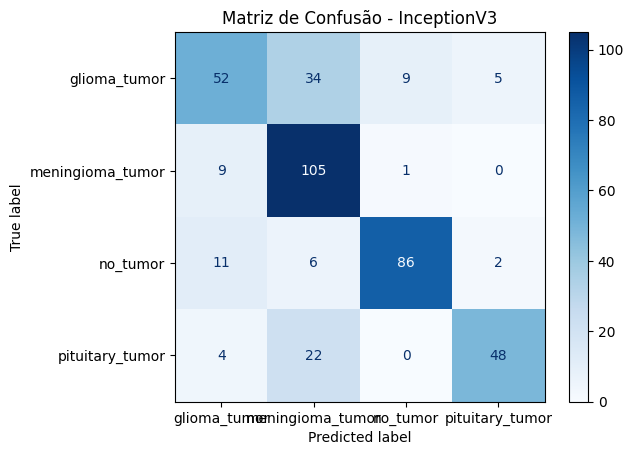

In [20]:
# Inception
print("--- Inception ---")
print("Treinamento com Parâmetros Fixos")
trained_inception_fixed = train_with_fixed_params(inception_model, fixed_dataloaders, epochs=5, lr=0.001, batch_size=32, optimizer_name="Adam", model_name="InceptionV3_Fixed")
evaluate_model(trained_inception_fixed, fixed_dataloaders['test'], model_name="InceptionV3_Fixed")

print("Treinamento com Otimização de Hiperparâmetros")
best_inception, inception_params = hyperparameter_optimization(inception_model, param_grid, epochs=5)
evaluate_model(best_inception, create_dataloaders(32)['test'], model_name="InceptionV3")

In [14]:
torch.cuda.empty_cache()

In [26]:
# Transformações específicas para DenseNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # DenseNet usa imagens de 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalização padrão
])

# Criar DataLoaders
fixed_dataloaders = {
    'train': DataLoader(datasets_dict['train'], batch_size=16, shuffle=True),
    'val': DataLoader(datasets_dict['val'], batch_size=16, shuffle=False),
    'test': DataLoader(datasets_dict['test'], batch_size=16, shuffle=False)
}

TREINO E AVALIAÇÃO DO MODELO DENSENET

--- DenseNet ---
Treinamento com Parâmetros Fixos


Validando: 100%|██████████| 55/55 [01:58<00:00,  2.15s/it]


Epoch 1/5, Loss: 0.5586, Train Accuracy: 79.51%
Validation Loss: 0.2535, Validation Accuracy: 91.58%



Validando: 100%|██████████| 55/55 [02:48<00:00,  3.07s/it]


Epoch 2/5, Loss: 0.3486, Train Accuracy: 87.87%
Validation Loss: 0.2600, Validation Accuracy: 89.85%



Validando: 100%|██████████| 55/55 [01:59<00:00,  2.18s/it]


Epoch 3/5, Loss: 0.3226, Train Accuracy: 88.43%
Validation Loss: 0.2830, Validation Accuracy: 91.00%



Validando: 100%|██████████| 55/55 [02:23<00:00,  2.60s/it]


Epoch 4/5, Loss: 0.2942, Train Accuracy: 89.23%
Validation Loss: 0.2605, Validation Accuracy: 90.31%



Validando: 100%|██████████| 55/55 [01:58<00:00,  2.16s/it]


Epoch 5/5, Loss: 0.2226, Train Accuracy: 91.78%
Validation Loss: 0.1186, Validation Accuracy: 95.85%

Accuracy: 0.7335
Precision: 0.7923
Recall: 0.7335
F1 Score: 0.6904


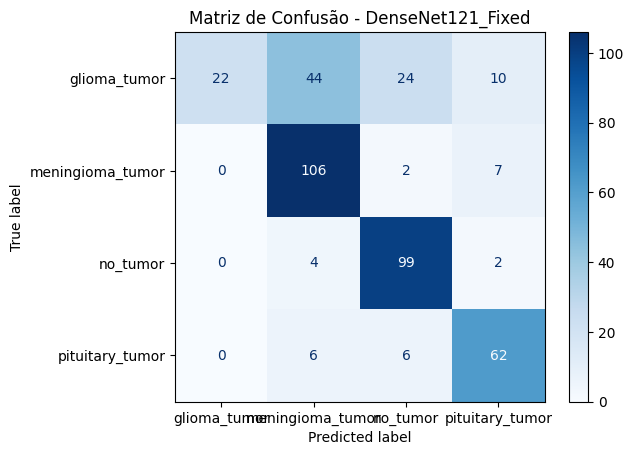

Treinamento com Otimização de Hiperparâmetros
Teste 1: lr=0.01, batch_size=16, optimizer=SGD


Validando: 100%|██████████| 55/55 [01:57<00:00,  2.13s/it]


Epoch 1/5, Loss: 0.1670, Train Accuracy: 94.22%
Validation Loss: 0.0917, Validation Accuracy: 96.66%



Validando: 100%|██████████| 55/55 [01:56<00:00,  2.12s/it]


Epoch 2/5, Loss: 0.2122, Train Accuracy: 94.15%
Validation Loss: 0.2044, Validation Accuracy: 93.89%



Validando: 100%|██████████| 55/55 [01:57<00:00,  2.14s/it]


Epoch 3/5, Loss: 0.2613, Train Accuracy: 93.21%
Validation Loss: 0.0266, Validation Accuracy: 98.96%



Validando: 100%|██████████| 55/55 [02:01<00:00,  2.21s/it]


Epoch 4/5, Loss: 0.2223, Train Accuracy: 93.83%
Validation Loss: 0.0195, Validation Accuracy: 99.31%



Validando: 100%|██████████| 55/55 [01:59<00:00,  2.17s/it]


Epoch 5/5, Loss: 0.1626, Train Accuracy: 95.78%
Validation Loss: 0.0440, Validation Accuracy: 98.62%

Acurácia de Validação: 98.62%
Teste 2: lr=0.001, batch_size=64, optimizer=SGD


Treinando - Epoch 1/5:   0%|          | 0/45 [00:00<?, ?it/s]

In [ ]:
# DenseNet
print("--- DenseNet ---")
print("Treinamento com Parâmetros Fixos")
trained_densenet_fixed = train_with_fixed_params(densenet_model, fixed_dataloaders, epochs=5, lr=0.001, batch_size=16, optimizer_name="Adam", model_name="DenseNet121_Fixed")
evaluate_model(trained_densenet_fixed, fixed_dataloaders['test'], model_name="DenseNet121_Fixed")


print("Treinamento com Otimização de Hiperparâmetros")
best_densenet, densenet_params = hyperparameter_optimization(densenet_model, param_grid, epochs=5)
evaluate_model(best_densenet, create_dataloaders(32)['test'], model_name="DenseNet121")
